# Feature study - Pombourg scene

This notebook details the geometric features for the `Pombourg` dataset. In order to illustrate the study, the screencast below represents the point cloud as seen with `CloudCompare`:

<img src="../../docs/images/pombourg.png" width="300px"></img>

## Imports

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
plt.style.use("seaborn-notebook")

In [5]:
from geo3dfeatures.io import las as read_las
from geo3dfeatures.extract import process_full
from geo3dfeatures.extract import compute_tree, request_tree, extract

## Data preparation

In [6]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"

In [7]:
DATAFOLDER = "data"

In [8]:
DATADIR = Path("../..", DATAFOLDER)

In [9]:
LABELS = {"eboulis": 0,
          "falaise": 1,
          "vegetation": 2}

In [10]:
# Coordinates labels
COORDS = list("xyz")
# RGB color labels
COULEURS = list("rgb")

In [11]:
rawdata = read_las(DATADIR / "input" / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [12]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


## Spatial index

In [13]:
LEAF_SIZE = 1_000
N_NEIGHBORS = 10

In [14]:
tree = compute_tree(rawdata[COORDS].values, leaf_size=LEAF_SIZE)

We request the KD-tree so as to retrieve the neighbors (k=10) of a given point, and the corresponding distances to it.

In [15]:
random_point = rawdata[COORDS].sample()
distance, neighbors_index = request_tree(random_point.values, tree, N_NEIGHBORS)
distance, neighbors_index = distance.squeeze(), neighbors_index.squeeze()
print("distance: ", distance)
print("index: ", neighbors_index)

distance:  [0.         0.04264103 0.0486145  0.0527144  0.057026   0.05876322
 0.06396685 0.06453085 0.06499725 0.08309187 0.08531755]
index:  [353101 353525 352937 352838 113375 353377 352936 348780 353376 352929
 353375]


Hence the following table contains the requested point (first row) and its 10 closest neighbors.

In [16]:
rawdata.loc[neighbors_index]

,x,y,z,r,g,b
353101,1.977548e+06,5.242322e+06,900.022627,146.0,135.0,127.0
353525,1.977548e+06,5.242322e+06,900.011107,161.0,151.0,143.0
352937,1.977548e+06,5.242322e+06,900.033873,150.0,140.0,133.0
352838,1.977548e+06,5.242322e+06,900.040694,157.0,147.0,139.0
113375,1.977548e+06,5.242322e+06,900.020827,143.0,131.0,125.0
353377,1.977548e+06,5.242322e+06,900.003676,143.0,131.0,126.0
352936,1.977548e+06,5.242322e+06,900.042998,159.0,149.0,141.0
348780,1.977548e+06,5.242322e+06,900.024077,140.0,127.0,119.0
353376,1.977548e+06,5.242322e+06,900.000990,162.0,152.0,145.0
352929,1.977548e+06,5.242322e+06,900.050627,158.0,149.0,141.0


We can compute some basic statistics about distance with neighbors (expressed in meters).

In [17]:
pd.Series(distance).describe()

count    11.000000
mean      0.056515
std       0.022795
min       0.000000
25%       0.050664
50%       0.058763
75%       0.064764
max       0.085318
dtype: float64

## Class sample features

We aim at computing all the features on every `Pombourg` sample, with respect to the entire scene. The subsequent geometric features can be computed considering a set of different neighborhood sizes.

### Dataset reading

In [18]:
vegetation = pd.DataFrame(read_las(DATADIR / "input" / VEGETATION_FILE), columns=COORDS + COULEURS)
falaise = pd.DataFrame(read_las(DATADIR / "input" / FALAISE_FILE), columns=COORDS + COULEURS)
eboulis = pd.DataFrame(read_las(DATADIR / "input" / EBOULIS_FILE), columns=COORDS + COULEURS)

In [19]:
print("Dimension of `vegetation` dataset: ", vegetation.shape)
print("dimension of `falaise` dataset: ", falaise.shape)
print("dimension of `eboulis` dataset: ", eboulis.shape)

Dimension of `vegetation` dataset:  (16850, 6)
dimension of `falaise` dataset:  (32440, 6)
dimension of `eboulis` dataset:  (24361, 6)


### Distance assessment with respect to neighborhood size

Let's consider the following neighborhood range:

In [20]:
VOISINS_NUM = [10, 20, 30, 50, 100, 200, 500, 1000, 1500, 2000]

We can have an insight about the neighboring sphere dimension by computing the mean distance (in meter) for each neighborhood size, *e.g.* by considering 20-point samples.

In [21]:
print("Vegetation neighborhood sizes:")
veg_sample = vegetation[COORDS].sample(20).values
gen = (request_tree(veg_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean (in meter)": d.mean(axis=1)[0], "max (in meter)": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM).T

Vegetation neighborhood sizes:


,10,20,30,50,100,200,500,1000,1500,2000
max (in meter),0.170637,0.236677,0.277909,0.365078,0.515782,0.704248,1.046811,1.483711,1.789040,2.052814
mean (in meter),0.107220,0.150850,0.186851,0.245903,0.348599,0.484510,0.720161,0.998461,1.214108,1.391522


In [22]:
print("Cliff neighborhood sizes:")
falaise_sample = falaise[COORDS].sample(20).values
gen = (request_tree(falaise_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean (in meter)": d.mean(axis=1)[0], "max (in meter)": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM).T

Cliff neighborhood sizes:


,10,20,30,50,100,200,500,1000,1500,2000
max (in meter),0.095365,0.13382,0.160445,0.210870,0.296547,0.414957,0.644140,0.902330,1.100380,1.268346
mean (in meter),0.062123,0.08780,0.107606,0.138929,0.196389,0.276995,0.432899,0.606784,0.739875,0.851770


With 1000 neighbors, the neighboring sphere is close to 1 meter.

### Feature study

We will compare some feature profile with respect to neighboring sphere size (resp. neighbor quantity), for each class (`falaise`, `eboulis`, `vegetation`).

In [23]:
FEATURE_PATH = Path("../..", DATAFOLDER, "output", PREFIX_NAME, "features")

**Disclaimer** The next cell must be run *after* running the featurization step for each scene sample.

Consider the following command, for each class:

```
geo3d featurize -d <datafolder> -i Pombourg_<class>.las -c r g b -t 500 -n 10 20 30 50 100 200 500 1000 1500 2000 --label-scene
```

where `datafolder` is the name of the data folder at the project root, on your file system, and `class` is the requested class (`vegetation`, `eboulis`, `falaise`).

In [24]:
vegetation_store = pd.HDFStore(FEATURE_PATH / "features_vegetation.h5", "r")
falaise_store = pd.HDFStore(FEATURE_PATH / "features_falaise.h5", "r")
eboulis_store = pd.HDFStore(FEATURE_PATH / "features_eboulis.h5", "r")

[10:26:09] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.


In [25]:
KEYS = {i: "/num_{:04d}".format(i) for i in VOISINS_NUM}

In [26]:
def mean_features(store, feature_name):
    result = pd.Series({num: store["/num_{:04d}".format(num)][feature_name].mean() for num in VOISINS_NUM})
    result.name = feature_name
    return result

#### Distance : radius & radius 2D

In [27]:
radius = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius"),
                       "falaise": mean_features(falaise_store, "radius"),
                       "eboulis": mean_features(eboulis_store, "radius")})

In [28]:
radius

,vegetation,falaise,eboulis
10,2.295291,1.212015,1.127756
20,2.295291,1.212015,1.127756
30,2.295291,1.212015,1.127756
50,2.295291,1.212015,1.127756
100,2.295291,1.212015,1.127756
200,2.295291,1.212015,1.127756
500,2.295291,1.212015,1.127756
1000,2.295291,1.212015,1.127756
1500,2.295291,1.212015,1.127756
2000,2.295291,1.212015,1.127756


Text(0, 0.5, 'Mean radius (m)')

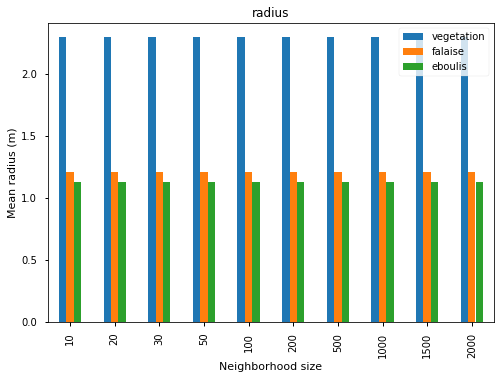

In [29]:
radius.plot(kind="bar", title="radius")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean radius (m)")

In [30]:
radius_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius_2D"),
                         "falaise": mean_features(falaise_store, "radius_2D"),
                         "eboulis": mean_features(eboulis_store, "radius_2D")})

Text(0, 0.5, 'Mean 2D radius (m)')

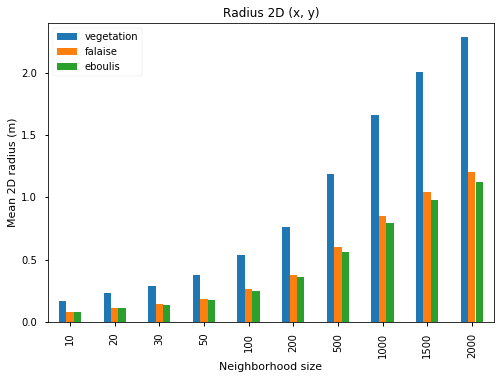

In [31]:
radius_2d.plot(kind="bar", title="Radius 2D (x, y)")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean 2D radius (m)")

#### Densité - 2D et 3D

In [32]:
key = "density_2D"
density_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean 2D density (m)')

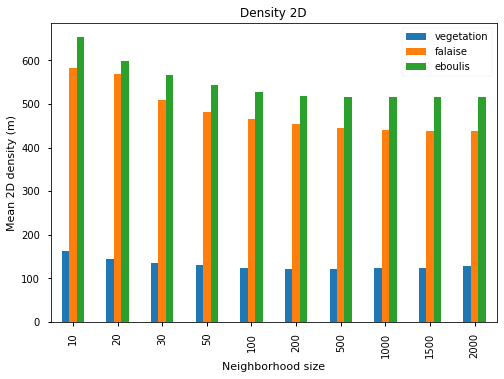

In [33]:
density_2d.plot(kind="bar", title="Density 2D")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean 2D density (m)")

In [34]:
key = "density"
density_3d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean density (m)')

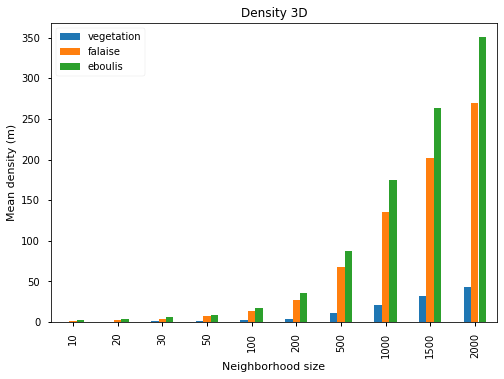

In [35]:
density_3d.plot(kind="bar", title="Density 3D")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean density (m)")

#### Autres features 2D : eigen sum & ratio

In [36]:
key = "eigenvalue_ratio_2D"
eigenratio_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean e2 / e1')

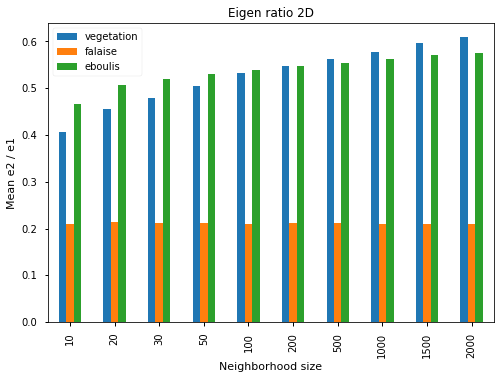

In [37]:
eigenratio_2d.plot(kind="bar", title="Eigen ratio 2D")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean e2 / e1")

In [38]:
key = "eigenvalue_sum_2D"
eigensum_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean eigenvalue sum')

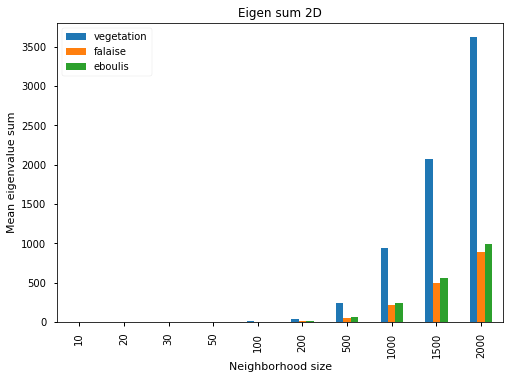

In [39]:
eigensum_2d.plot(kind="bar", title="Eigen sum 2D")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean eigenvalue sum")

#### alpha & beta

In [40]:
alpha = pd.DataFrame({"vegetation": mean_features(vegetation_store, "alpha"),
                     "falaise": mean_features(falaise_store, "alpha"),
                     "eboulis": mean_features(eboulis_store, "alpha")})

The bigger the `alpha`, the more 1D the dataset.

Text(0, 0.5, 'alpha')

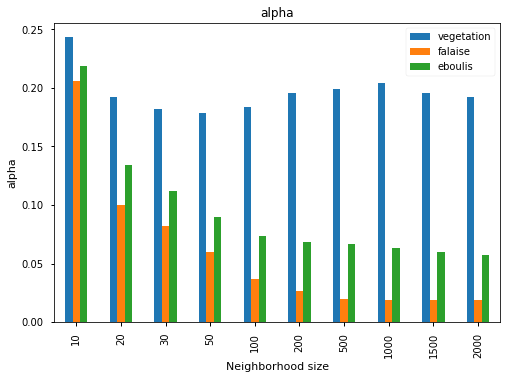

In [41]:
alpha.plot(kind='bar', title="alpha")
plt.xlabel("Neighborhood size")
plt.ylabel("alpha")

In [42]:
beta = pd.DataFrame({"vegetation": mean_features(vegetation_store, "beta"),
                     "falaise": mean_features(falaise_store, "beta"),
                     "eboulis": mean_features(eboulis_store, "beta")})

The bigger `beta` is, the more 2D the dataset.

Text(0, 0.5, 'beta')

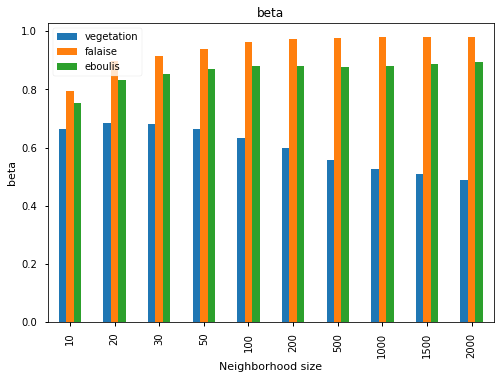

In [43]:
beta.plot(kind="bar", title="beta")
plt.xlabel("Neighborhood size")
plt.ylabel("beta")

Then, the bigger `1 - (alpha + beta)` is, the more 3D the dataset.

Text(0, 0.5, '1 - (alpha + beta)')

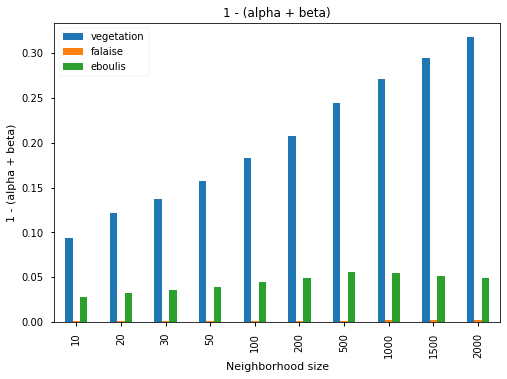

In [44]:
(1 - (alpha + beta)).plot(kind="bar", title='1 - (alpha + beta)')
plt.xlabel("Neighborhood size")
plt.ylabel("1 - (alpha + beta)")

We want to plot the evolution of these features for each class, with respect to neighborhood size.

In [45]:
triangle_vegetation = pd.DataFrame({"alpha": mean_features(vegetation_store, "alpha"),
                     "beta": mean_features(vegetation_store, "beta")})

triangle_vegetation["gamma"] = triangle_vegetation.eval("1 - alpha - beta")

In [46]:
triangle_vegetation

,alpha,beta,gamma
10,0.243248,0.663366,0.093386
20,0.192339,0.686297,0.121363
30,0.182236,0.680104,0.137660
50,0.178741,0.663827,0.157432
100,0.183587,0.633578,0.182835
200,0.195480,0.597182,0.207338
500,0.198764,0.557242,0.243995
1000,0.203904,0.524745,0.271351
1500,0.195272,0.509812,0.294917
2000,0.192241,0.490183,0.317576


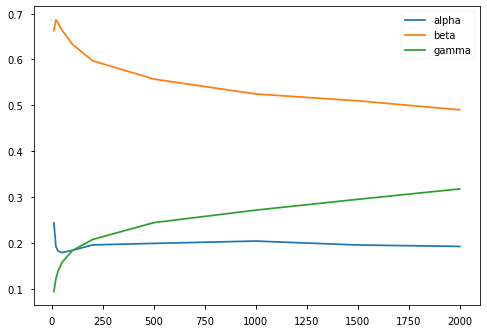

In [47]:
triangle_vegetation.plot()

In [48]:
triangle_falaise = pd.DataFrame({"alpha": mean_features(falaise_store, "alpha"),
                     "beta": mean_features(falaise_store, "beta")})

triangle_falaise["gamma"] = triangle_falaise.eval("1 - alpha - beta")

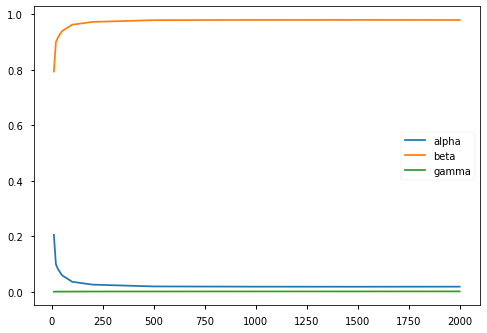

In [49]:
triangle_falaise.plot()

In [50]:
triangle_eboulis = pd.DataFrame({"alpha": mean_features(eboulis_store, "alpha"),
                     "beta": mean_features(eboulis_store, "beta")})

triangle_eboulis["gamma"] = triangle_eboulis.eval("1 - alpha - beta")

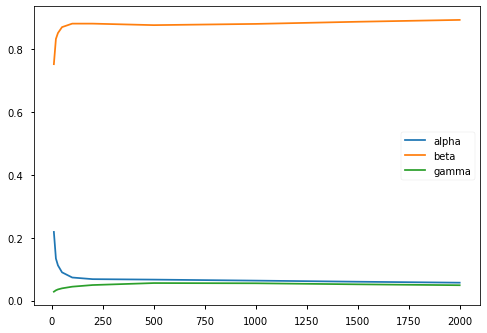

In [51]:
triangle_eboulis.plot()

#### Verticality coefficient

In [52]:
key = "verticality"
verticality = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Verticality')

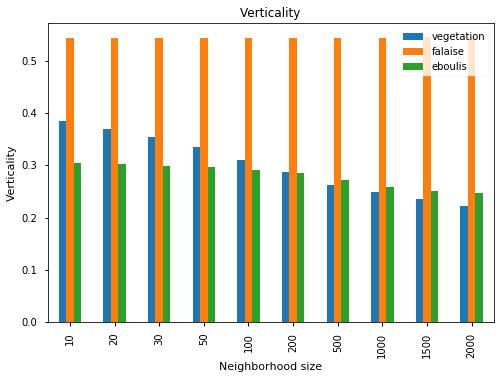

In [53]:
verticality.plot(kind="bar", title="Verticality")
plt.xlabel("Neighborhood size")
plt.ylabel("Verticality")

#### Linerarity, planarity & scattering

In [54]:
key = "linearity"
linearity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean (e1-e2)/e1')

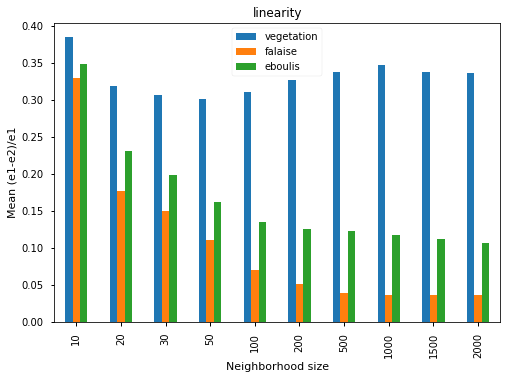

In [55]:
linearity.plot(kind="bar", title="linearity")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean (e1-e2)/e1")

In [56]:
key = "planarity"
planarity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean (e2 - e3)/e1')

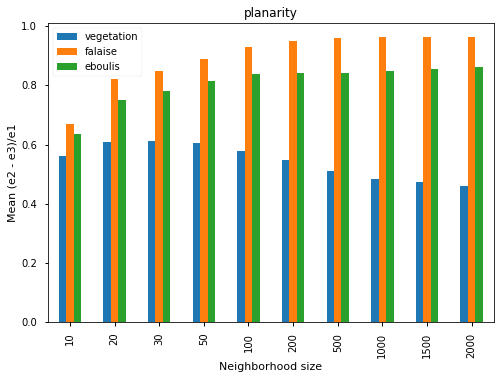

In [57]:
planarity.plot(kind="bar", title="planarity")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean (e2 - e3)/e1")

In [58]:
key = "scattering"
scattering = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean e3 / e1')

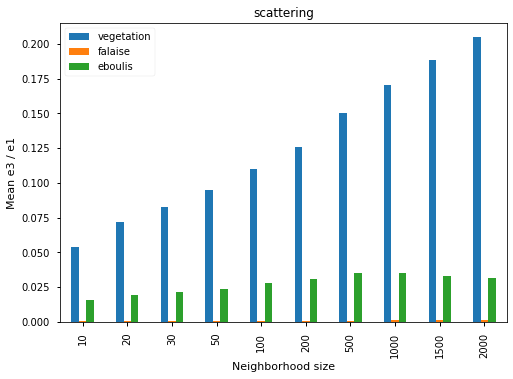

In [59]:
scattering.plot(kind="bar", title="scattering")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean e3 / e1")

#### Curvature Change

In [60]:
key = "curvature_change"
curvature = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean e3 / (sum e_i)')

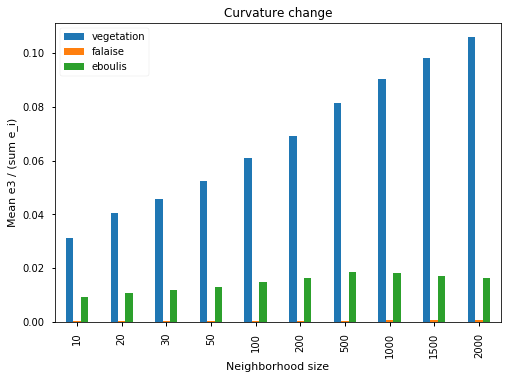

In [61]:
curvature.plot(kind="bar", title="Curvature change")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean e3 / (sum e_i)")

#### Omnivariance

In [62]:
key = "omnivariance"
omnivariance = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean sqrt(e1*e2*e3)')

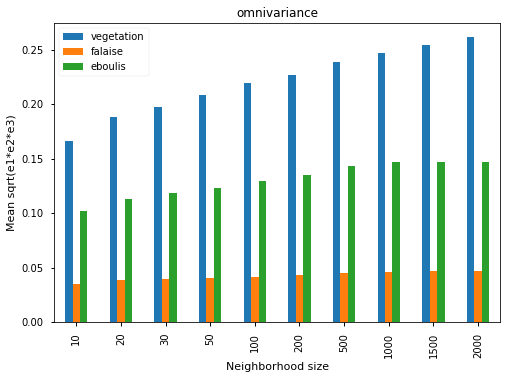

In [63]:
omnivariance.plot(kind="bar", title="omnivariance")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean sqrt(e1*e2*e3)")

#### Anisotropy

In [64]:
key = "anisotropy"
anisotropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean (e1 - e3)/e1')

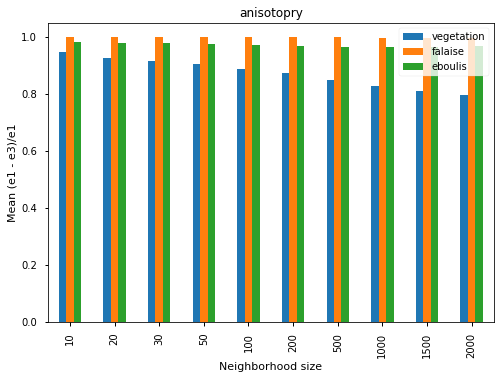

In [65]:
anisotropy.plot(kind="bar", title="anisotopry")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean (e1 - e3)/e1")

#### Eigentropy

In [66]:
key = "eigenentropy"
eigentropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean -sum(e_i * ln e_i)')

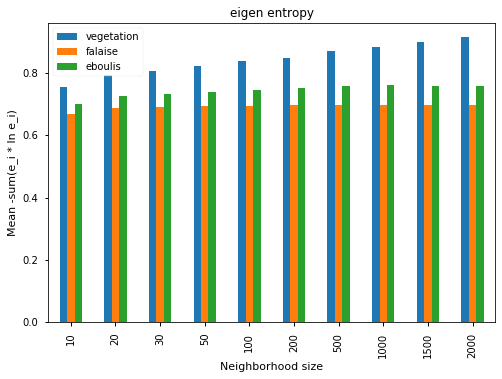

In [67]:
eigentropy.plot(kind="bar", title="eigen entropy")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean -sum(e_i * ln e_i)")

#### Eigenvalues Sum

In [68]:
key = "eigenvalue_sum"
eigensum = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'Mean sum(lambda_i)')

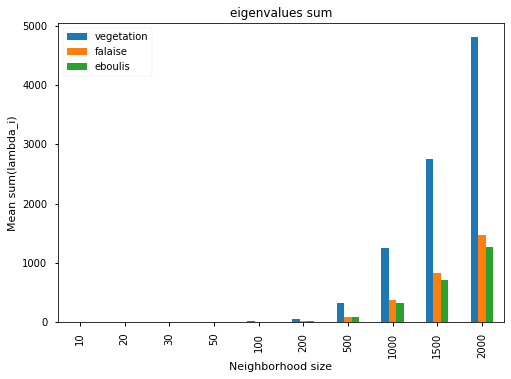

In [69]:
eigensum.plot(kind="bar", title="eigenvalues sum")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean sum(lambda_i)")

### Feature correlation

After concatenating the dataframes of different neighborhood sizes, we can compute a correlation matrix to have an insight of mathematical relations between our variables.

In [70]:
VOISIN_30 = "/num_0030"    # rayon sphère environ 20cm
VOISIN_1000 = "/num_1000"  # rayon sphère environ 1m

In [71]:
FEATURE_NAMES =  ['alpha',
 'beta',
 'radius',
 'z_range',
 'std_dev',
 'density',
 'verticality',
 'curvature_change',
 'linearity',
 'planarity',
 'scattering',
 'omnivariance',
 'anisotropy',
 'eigenentropy',
 'eigenvalue_sum',
 'radius_2D',
 'density_2D',
 'eigenvalue_sum_2D',
 'eigenvalue_ratio_2D']

In [72]:
def concat_features(voisin_num):
    return pd.concat([vegetation_store[voisin_num],
                      falaise_store[voisin_num],
                      eboulis_store[voisin_num]], axis=0, ignore_index=True)

In [73]:
features_30 = concat_features(VOISIN_30)

In [74]:
features_1000 = concat_features(VOISIN_1000)

In [75]:
features_1000.columns

Index(['x', 'y', 'z', 'num_neighbors', 'alpha', 'beta', 'radius', 'z_range',
       'std_dev', 'density', 'verticality', 'curvature_change', 'linearity',
       'planarity', 'scattering', 'omnivariance', 'anisotropy', 'eigenentropy',
       'eigenvalue_sum', 'radius_2D', 'density_2D', 'eigenvalue_sum_2D',
       'eigenvalue_ratio_2D', 'r', 'g', 'b'],
      dtype='object')

In [76]:
rho_30 = features_30[FEATURE_NAMES].corr()

In [77]:
rho_1000 = features_1000[FEATURE_NAMES].corr()

We can re-order the feature names.

In [78]:
cols = pd.Index(['beta', 'planarity', 'anisotropy', 'density_2D', 'density',
       'verticality', 'eigenvalue_ratio_2D', 'eigenvalue_sum_2D',
       'eigenvalue_sum', 'radius_2D', 'radius', 'std_dev', 'z_range', 'alpha',
       'linearity', 'eigenentropy', 'omnivariance', 'scattering',
       'curvature_change'])

We have the following feature correlation matrix for 30 neighbors.

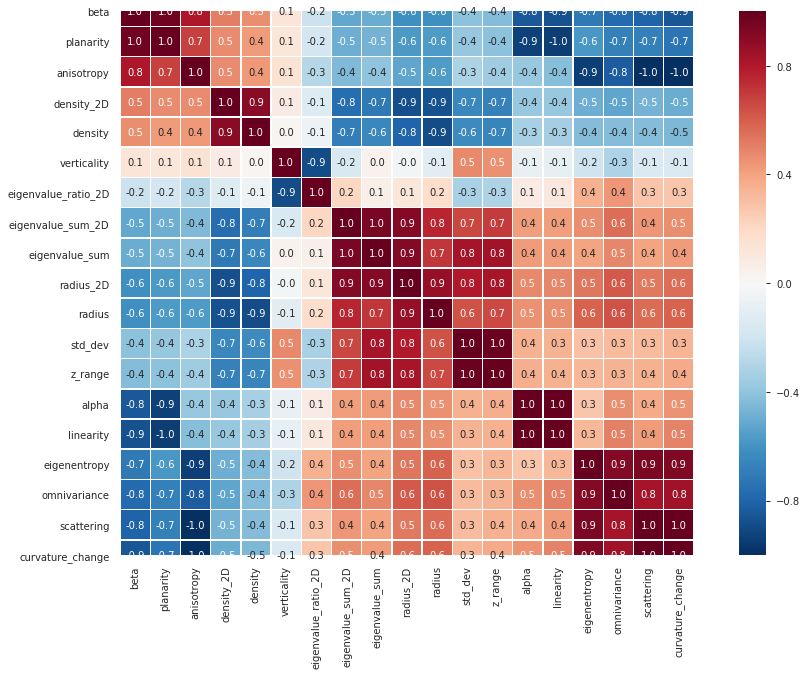

In [79]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_30.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

Then let's plot the same information for 1000 neighbors.

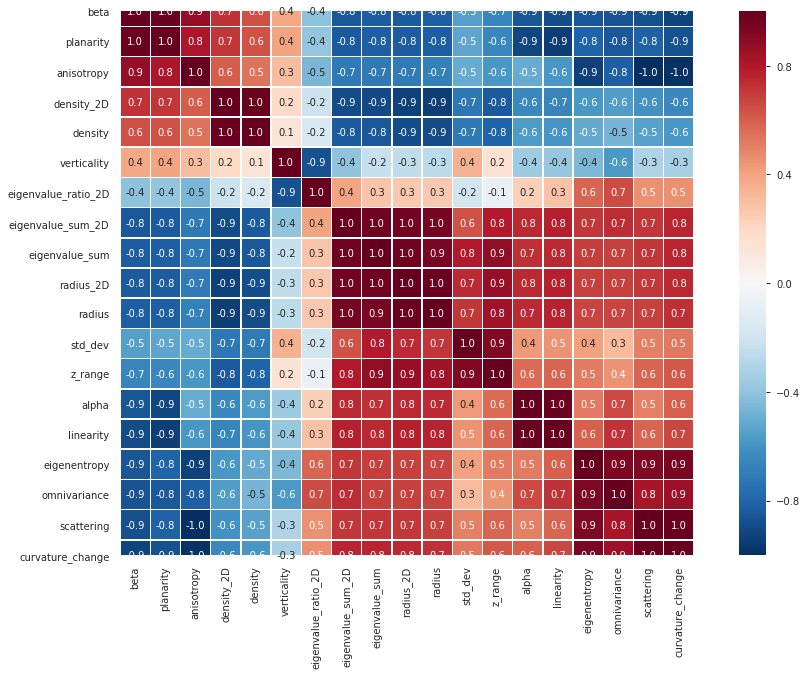

In [80]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_1000.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

### Running a PCA on geometric features

In order to run this additional analysis, we need a few more dependencies.

In [81]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [82]:
from geo3dfeatures.tools.kmean import load_features
from geo3dfeatures.features import max_normalize

As a first attempt to remove colinearities between the features in a generalisable way, we can apply Principle Component Analysis to the point cloud features for the whole scene, and for a small set of neighborhood sizes.

In [83]:
scene_store = vegetation_store = pd.HDFStore(FEATURE_PATH / "features.h5", "r")

In [84]:
SCENE_NEIGHBORHOODS = [50, 200, 1000]

In [85]:
features = load_features(Path("..", "..", DATAFOLDER), "Pombourg", SCENE_NEIGHBORHOODS)

[10:27:09] kmean.load_features (INFO) - Recover features stored in ../../data/output/Pombourg/features/features.h5


In [86]:
features.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50', 'r',
       'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'std_dev_200', 'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'alpha_1000', 'beta_1000', 'radius_1000',
       'z_range_1000', 'std_dev_1000', 'density_1000', 'verticality_1000',
       'curvature_change_1000', 'linearity_1000', 'planarity_1000',
       'scattering_1000', 'omnivari

We consider a standardized version of the data.

In [87]:
norm_features = StandardScaler().fit_transform(features.drop(columns=["x", "y"]))

Then we run a PCA with 10 components, by assuming that the whole information can be summarized in less dimensions.

In [88]:
model = PCA(10).fit(norm_features)

As depicted by the following plot, the first component explain a large part of the model variance (~50%), whilst a projection on a 3 dimension space can explain 75% of the variance.

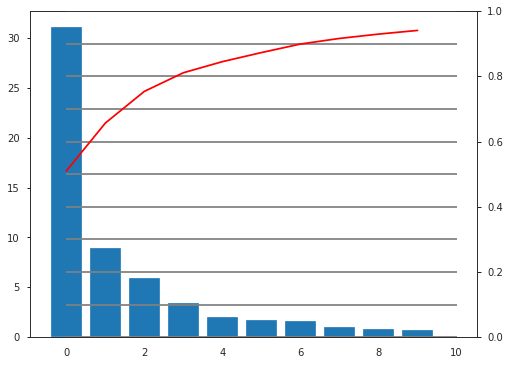

In [89]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(model.n_components), model.explained_variance_)
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.plot(range(model.n_components), np.cumsum(model.explained_variance_ratio_), "r")
    ax2.hlines(y=np.linspace(0, 1, 11), xmin=0, xmax=10, color='gray')

To enhance the insight on the state of features, we can plot all of them in a big heatmap...

In [90]:
pca_components = pd.DataFrame(model.components_.T, index=features.drop(columns=["x", "y"]).columns)

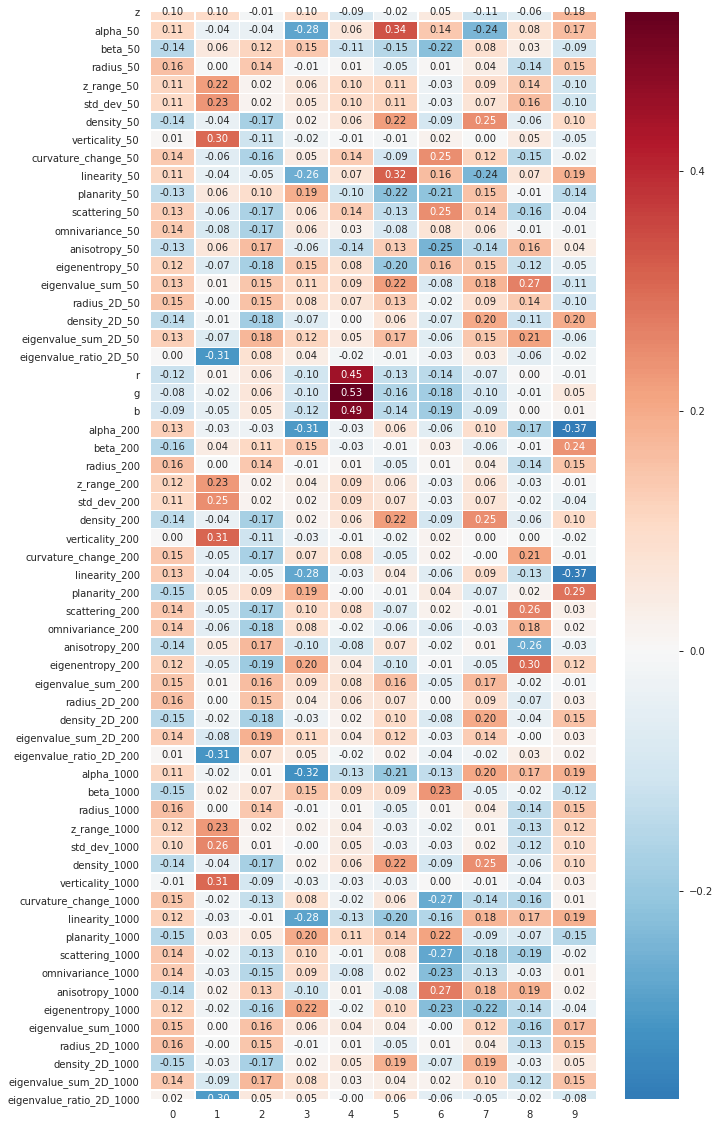

In [91]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(10, 20))
    sns.heatmap(pca_components, cmap='RdBu_r', fmt=".2f", ax=ax, center=0., linewidths=0.5, annot=True)

As a summary, we can see that the first component mixes a large part of the features, and the different neighborhood sizes do not really introduce variability. The second component brings a different information, based on verticality coefficients and 2D eigenvalue ratios. The third component is a slight variation of the first one. The fifth component is noticeable as it contains information about the color (with no particular distinction between RGB channels).

** **TDLR Interpretation through PCA can bring further insights on data, and confirm the information provided by correlation matrix. However a raw use of PCA components as explicative variables in a (un)supervised learning algorithm does not seem relevant.** **